# Is it Sonic the Hedgehog?
As we all know, this fellow is often confused in-universe with other fellow anthropomorphic creatures. Let's see how this Binary Classification fares!

## SETUP
Let's follow the setup done by fast.ai
We'll check the connection and install the packages needed.

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
!pip install -Uqq fastai duckduckgo_search
!pip install scipy --upgrade

  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/f5/aa/8e6071a5e4dca4ec68b5b22e4991ee74c59c5d372112b9c236ec1faff57d/scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 27.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is inco

In [4]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    #Current form was deprecated. Switching to: https://stackoverflow.com/a/76711510
    #return L(DDGS().images(term, max_results=max_images)).itemgot('image')
    #Also from: https://stackoverflow.com/a/76700197
    with DDGS() as ddgs:
        search_results = ddgs.images(keywords=term)
        print("Search result successful")
        images_list = [next(search_results).get("image") for _ in range(max_images)]
        return L(images_list)

urls = search_images("sonic the hedgehog pose", 1)

Searching for 'sonic the hedgehog pose'
Search result successful


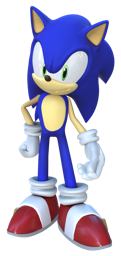

In [5]:

from fastdownload import download_url
dest = 'sonic.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'shadow the hedgehog pose'
Search result successful


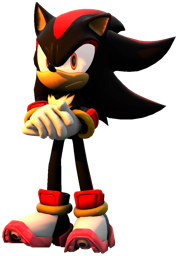

In [6]:
download_url(search_images('shadow the hedgehog pose', max_images=1)[0], 'shadow.jpg', show_progress=False)
Image.open('shadow.jpg').to_thumb(256,256)

In [7]:
searches = 'sonic the hedgehog pose','shadow the hedgehog pose'
path = Path('sonic_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)  # Pause between searches to avoid over-loading server
    #download_images(dest, urls=search_images(f'{o} sun photo'))
    #sleep(10)
    #download_images(dest, urls=search_images(f'{o} shade photo'))
    #sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'sonic the hedgehog pose'
Search result successful
Searching for 'shadow the hedgehog pose'
Search result successful


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Delete failed images


In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

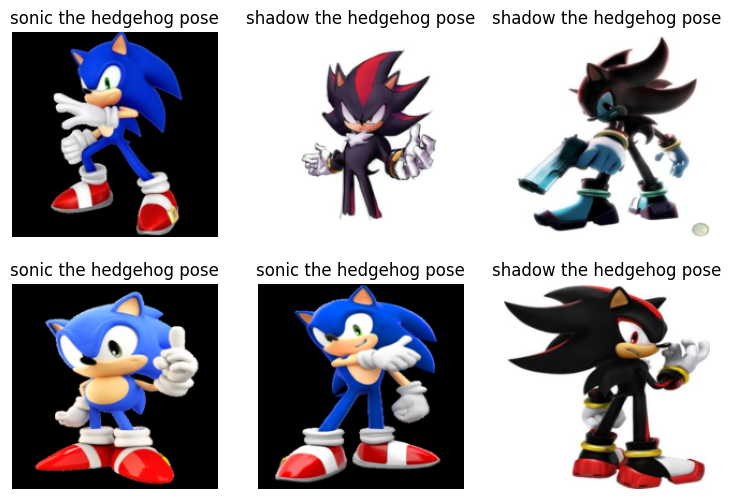

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)


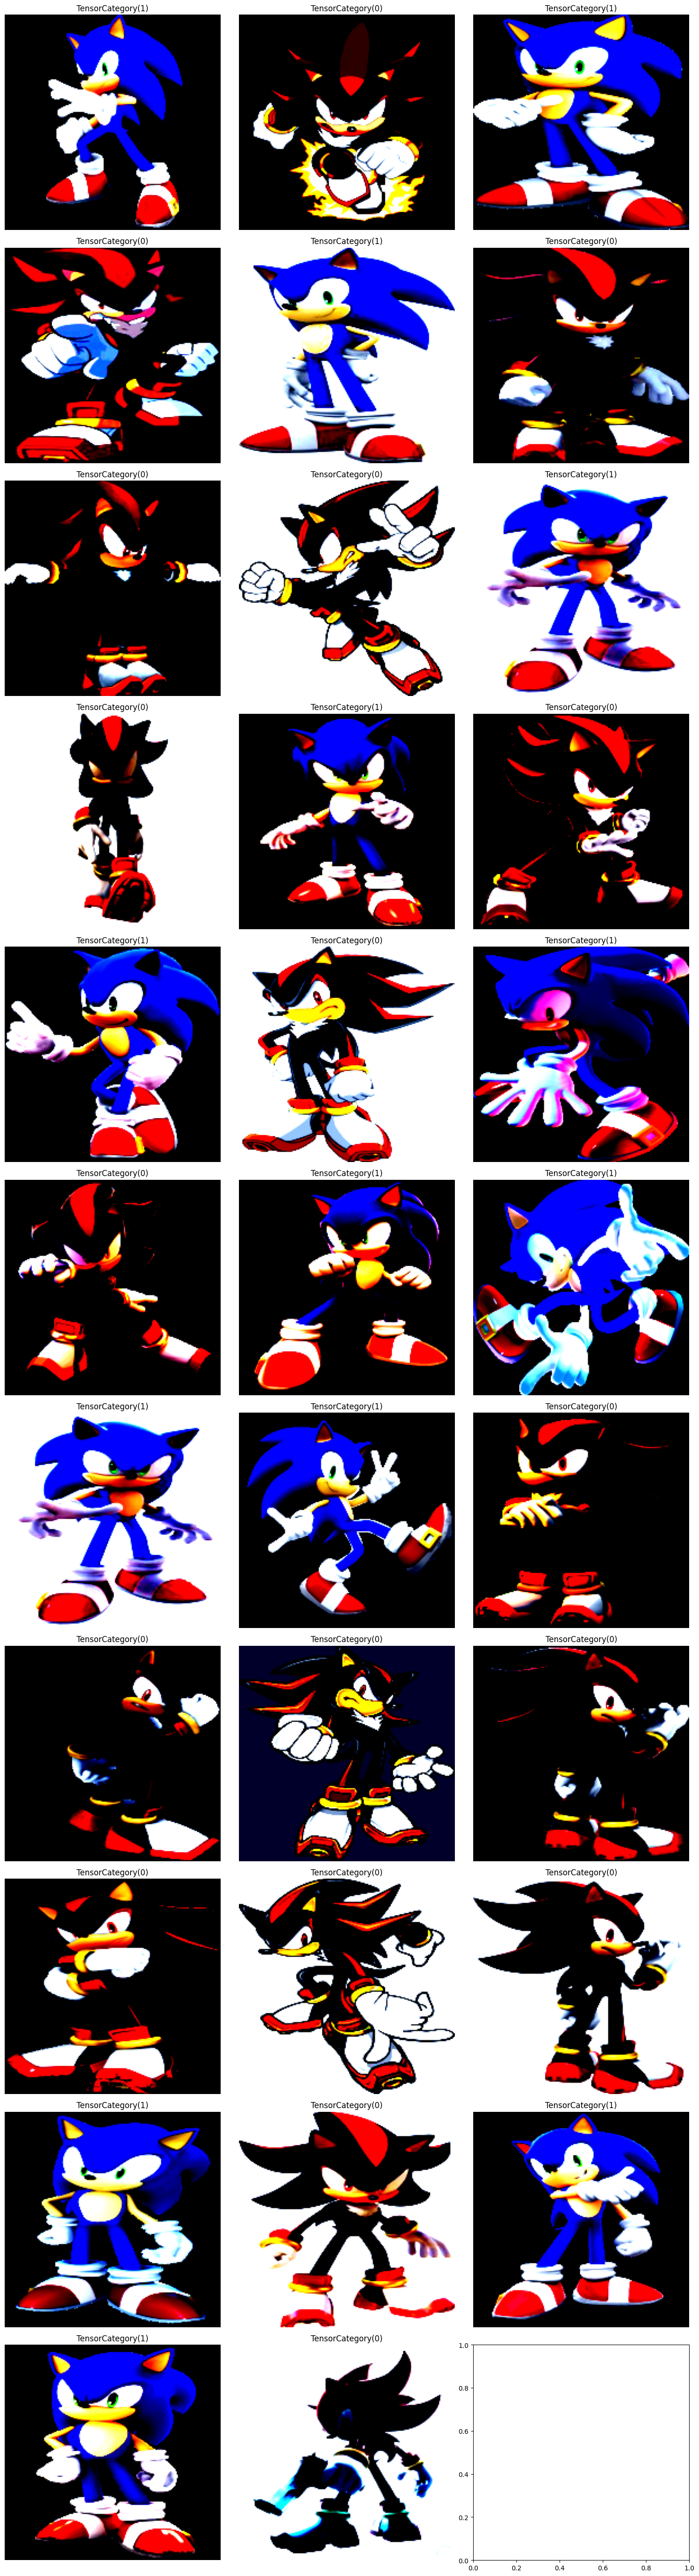

In [36]:
#While I've done this strategic grid at work using pure thoughts
# here I didn't want to linger too much on this part, as it's mostly for debugging purposes
# so I got some AI help to get the grid printing going.

num_images = len(images)
num_cols = 3
num_rows = (num_images + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for batch in dls.train:
    images, labels = batch
    
    for i, (image,label) in enumerate(zip(images, labels)):
        image_np = image.permute(1, 2, 0).numpy()
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(image_np)
        ax.set_title(label)
        ax.axis('off')

plt.tight_layout()
plt.show()

In [26]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.153275,2.959160,0.500000,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.244425,2.181611,0.500000,00:07
1,0.859831,1.207334,0.500000,00:08
2,0.633573,0.785184,0.300000,00:08


Searching for 'sonic the hedgehog pose'
Search result successful


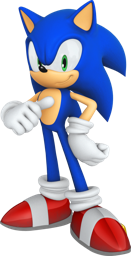

In [39]:
#Download another image
img_urls = search_images("sonic the hedgehog pose", 1)
dest = 'sonic3.jpg'
download_url(img_urls[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

probs: tensor([0.9090, 0.0910])
Is this sonic? - shadow the hedgehog pose.
Probability it's Sonic: 0.0910


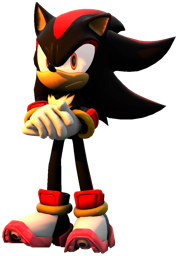

In [42]:
is_sonic,_,probs = learn.predict(PILImage.create('shadow.jpg'))
print(f"probs: {probs}")
print(f"Is this sonic? - {is_sonic}.")
print(f"Probability it's Sonic: {probs[1]:.4f}")
Image.open('shadow.jpg').to_thumb(256,256)

After some testing, seems like Sonic was assigned TensorCategory(1).
Thus, the model is correctly guessing who's Sonic.
It's just we had the printing wrong.

Now we can prove that this Neural Network is better than the Sonic Adventure 2 dudes at telling Sonic and Shadow apart. Wow!